In [173]:
import numpy as np
from math import sin, cos
import matplotlib.pyplot as plt
from scipy.stats import norm as normal_dist
from time import time
import pyaudio

plt.rcParams['figure.figsize'] = [30, 10]
names = ["A BbB C DbD EbE F GbG Ab"[(i%12)*2:(i%12)*2+2].strip() + str(i//12) for i in range(120)]

In [184]:
CHUNK = 4096
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 15
WAVE_OUTPUT_FILENAME = "output.wav"

In [185]:
# Generate FFT_S and FFT_C
s = time()

slen = CHUNK

num_notes = 120
num_segments = 1

logs = (np.arange(num_notes * num_segments) - (num_segments//2)) * (1/(12 * num_segments))
freqs = 27.5 * 2**logs

nfft_s = np.zeros((len(freqs), slen))
nfft_c = np.zeros((len(freqs), slen))

rate = 44100

for i in range(len(freqs)):
    seconds = slen/rate
    num_cycles = seconds * freqs[i] # i.e 55 hz * (2048/44100) = 2.55 cycles
    n = num_cycles * 2 * np.pi
    nfft_s[i] = np.arange(slen) * (n/slen)
    nfft_c[i] = np.arange(slen) * (n/slen)
#     for j in range(slen):
#         nfft_s[i][j] = (n*j/slen)
#         nfft_c[i][j] = (n*j/slen)

nfft_s = np.sin(nfft_s)
nfft_c = np.cos(nfft_c)
m = time()

# Generate COND
condense = np.zeros((120, 12))
for i in range(120):
    condense[i][i%12] = 1 
    

# Generate HMAT

sigma = 1/36
notes = [(i/12) for i in range(120)]
mat = np.zeros((len(logs), len(notes)))
# each value in mat is the probability that a fft frequency belongs to a note or it's harmonic series
for i in range(len(logs)):
#         print(i, end="\r")
    for j in range(len(notes)):
        v = abs(logs[i] - notes[j])
        mat[i][j] = (v/sigma)
mat = 2 * (1- normal_dist().cdf(mat))

# Generate H_INV
inv_harm = np.zeros((120,120))
for i in range(120):
    for j in [0, 12, 19, 24, 28, 31]: #harmonic series is +12, +7, +5, +4, +3
        if i + j < 120:
            inv_harm[i][i+j] = 1

e = time()

print(e - s, "seconds taken to generate all matrices", (e-s)/(1/44100))
print(m - s, "seconds to generate FFT", (m-s)/(1/44100))

0.07330727577209473 seconds taken to generate all matrices 3232.8508615493774
0.04851126670837402 seconds to generate FFT 2139.3468618392944


highest granularity needed: 7.6756894297203e-06


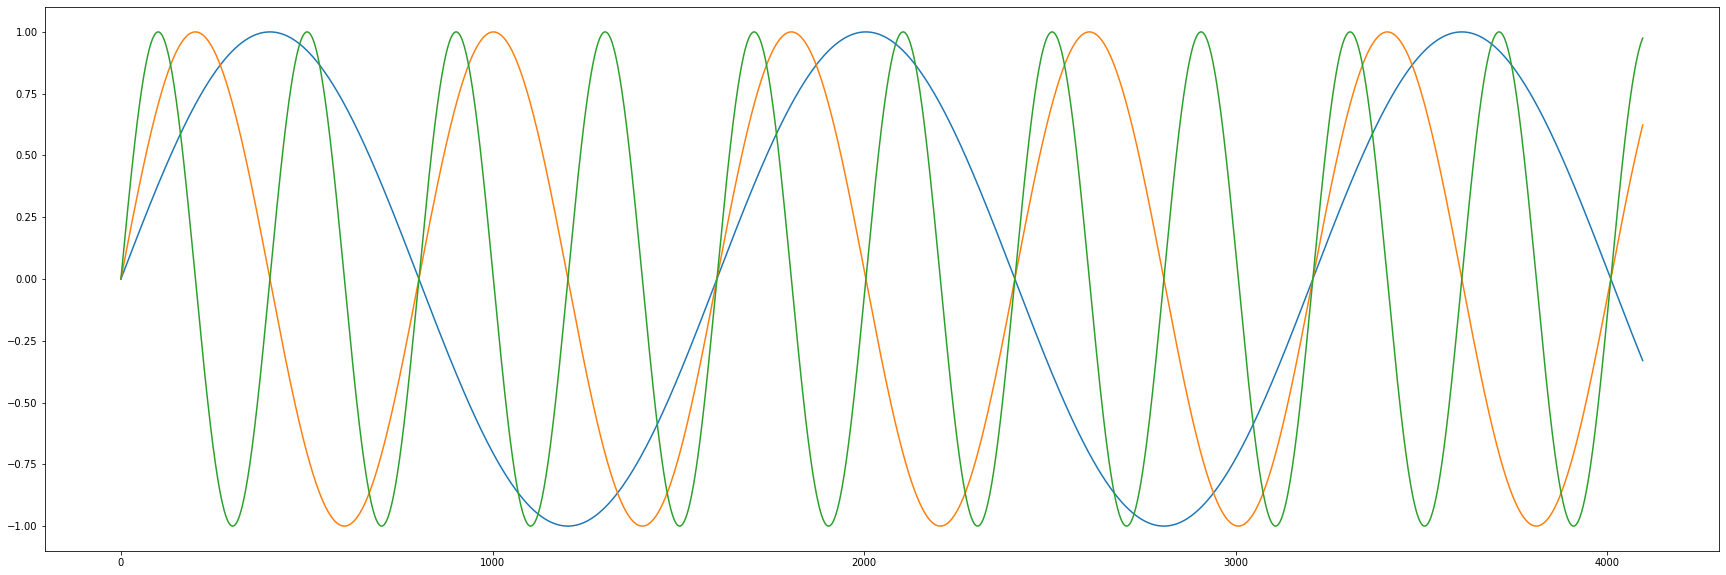

In [176]:
for i in range(10): 
    for j in range(12):
        assert np.linalg.norm(nfft_s[j][0::(2**i)] - nfft_s[12*i + j][:(slen >> (i))]) < 1e-8

# smallest delta in any of the functions
print("highest granularity needed:" , (1 - cos(1/2048 * (2048/44100 * 27.5 * 2 * np.pi))))

plt.plot(nfft_s[0])
plt.plot(nfft_s[12])
plt.plot(nfft_s[24])

In [177]:
def find_note_2(sample, FFTS, FFTC, COND, verbose=False):
    dft2s = np.matmul(FFTS, sample) # (120, 2048) x (2048, 1) -> (120,1)
    dft2c = np.matmul(FFTC, sample) # (120, 2048) x (2048, 1) -> (120,1)
    psd2 = ((dft2s**2) + (dft2c**2)) # (120, 1) + (120, 1) -> (120, 1)
    c = np.matmul(psd2, COND) # (12,120) x (120, 1) -> (12, 1)
#     c /= np.linalg.norm(c)
    c /= max(c)
    
    
    return list(zip(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"],c))
#     psd = psd2 * psd2

In [178]:
def find_note(sample, FFTS, FFTC, HMAT, H_INV, COND, verbose=False):
    dft2s = np.matmul(FFTS, sample)
    dft2c = np.matmul(FFTC, sample)
    psd2 = ((dft2s**2) + (dft2c**2))**0.5
    psd_n = np.matmul(psd2, HMAT)

    nl = np.matmul(H_INV, psd_n) # (120,120) (120,1) = (120,1)
    nr = np.matmul(H_INV.T, psd_n) # (120,120) (120,1) = (120,1)
    
    #(120,1) (1,120) = (120,120)
    
    #nl = diag(Hn (H.Tn).T)= diag(Hnn.TH)
    nlr = nl * nr
    
    c = np.matmul(nlr, COND)
    c /= np.linalg.norm(c)
    
    
    if verbose:
        
        # NEW STUFF
    
        print(nl.shape, nr.shape)

        nl2 = np.reshape(nl, (120,1))
        nr2 = np.reshape(nr, (1,120))

        m = np.matmul(nl2, nr2)
        print(m.shape)

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.imshow(m)
        plt.show()

        print("Outer product of psd")
        psdn2 = np.reshape(psd_n, (120,1))
        m2 = np.matmul(psdn2, psdn2.T)
        print(m2.shape)

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.imshow(m2)
        plt.show()

        # NEW STUFF END
    
        
        print("PSD of modified FFT")
        plt.bar(range(len(psd2)), psd2)
        plt.show()
        
        print("PSD of modified FFT converted to notes")
        plt.bar(range(len(psd_n)), psd_n)
        plt.show()
        
        print("Left harmonic series")
        plt.bar(range(len(nl)), nl)
        plt.show()
        
        print("Right harmonic series")
        plt.bar(range(len(nr)), nr)
        plt.show()
        
        print("harmonic series multiplied")
        plt.bar(range(len(nlr)), nlr)
        plt.show()
        
        print("psd")
        plt.bar(range(len(nlr)), psd2**2)
        plt.show()
        
        print("final answer")
        plt.bar(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"], c)
        plt.show()
        print(list(zip(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"],c)))
        
        print("final answer 2")
        c2 = np.matmul((psd2**2), COND)
        c2 /= np.linalg.norm(c2)
        plt.bar(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"], c2)
        plt.show()
        print(list(zip(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"],c2)))
   
    return list(zip(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"],c))

In [179]:
def find_note_3(sample, FFTS, FFTC, verbose=False):
    dft2s = np.matmul(FFTS, sample)
    dft2c = np.matmul(FFTC, sample)
    psd2 = ((dft2s**2) + (dft2c**2))
    
    ret = np.zeros(12)
    for i in range(120):
        s = dft2s[i]
        c = dft2c[i]
        ret[i%12] += s*s + c*c
    ret /= np.linalg.norm(ret)
    
    return list(zip(["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"],np.round(ret, 6)))

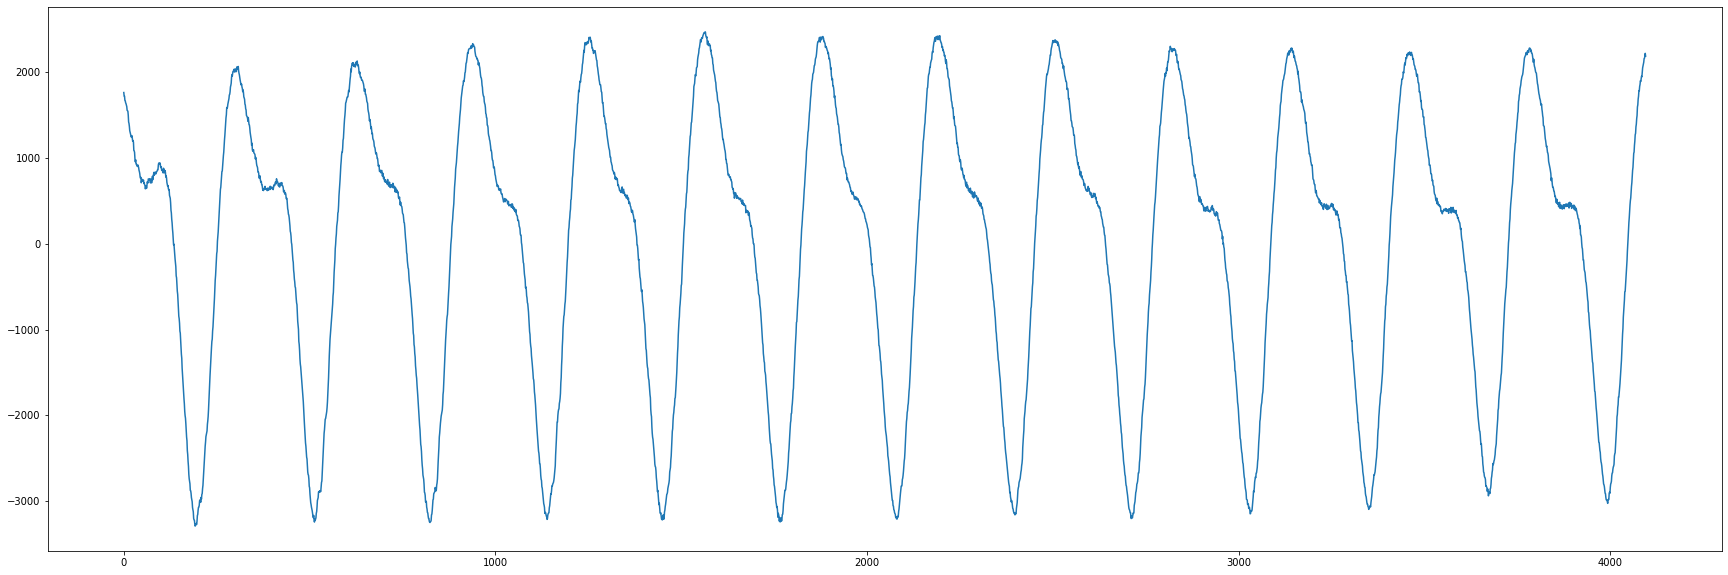

[0.008807, 0.00645, 0.034338, 0.051262, 0.975095, 0.209017, 0.035436, 0.011599, 0.005077, 0.00597, 0.004241, 0.010333]


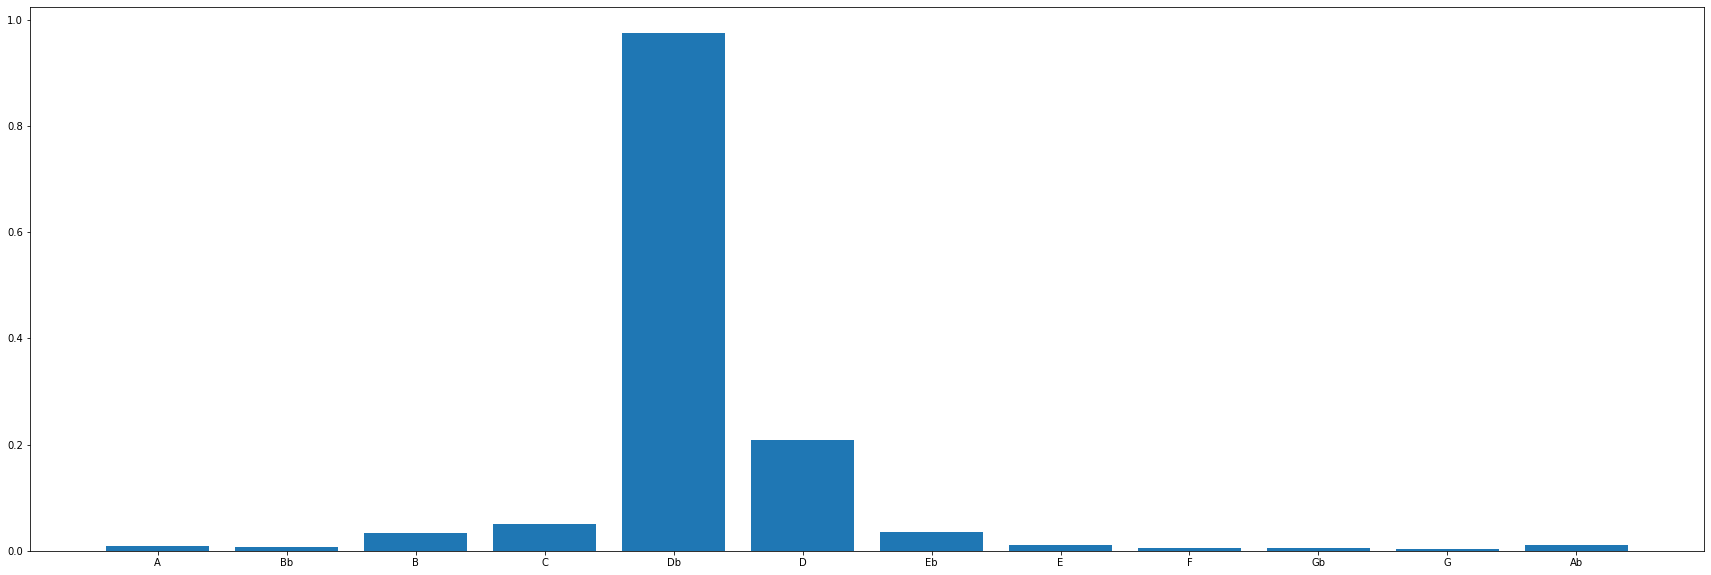

In [204]:
f = open("samples.csv")
r = f.read().strip().split("\n")
f.close()

sample = np.asarray([int(n) for n in r]).astype(np.float64)

assert len(sample) == slen 

plt.plot(sample)
plt.show()

n = find_note_3(sample, nfft_s, nfft_c)
print([v[1] for v in n])
plt.bar([v[0] for v in n], [v[1] for v in n])
plt.show()

(120,) (120,)
(120, 120)


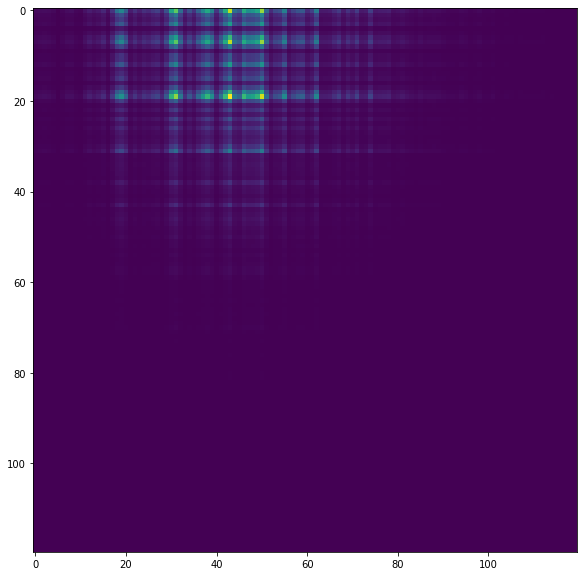

Outer product of psd
(120, 120)


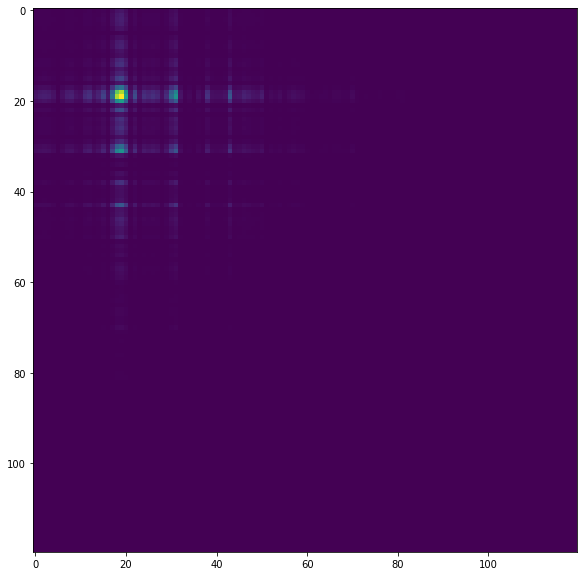

PSD of modified FFT


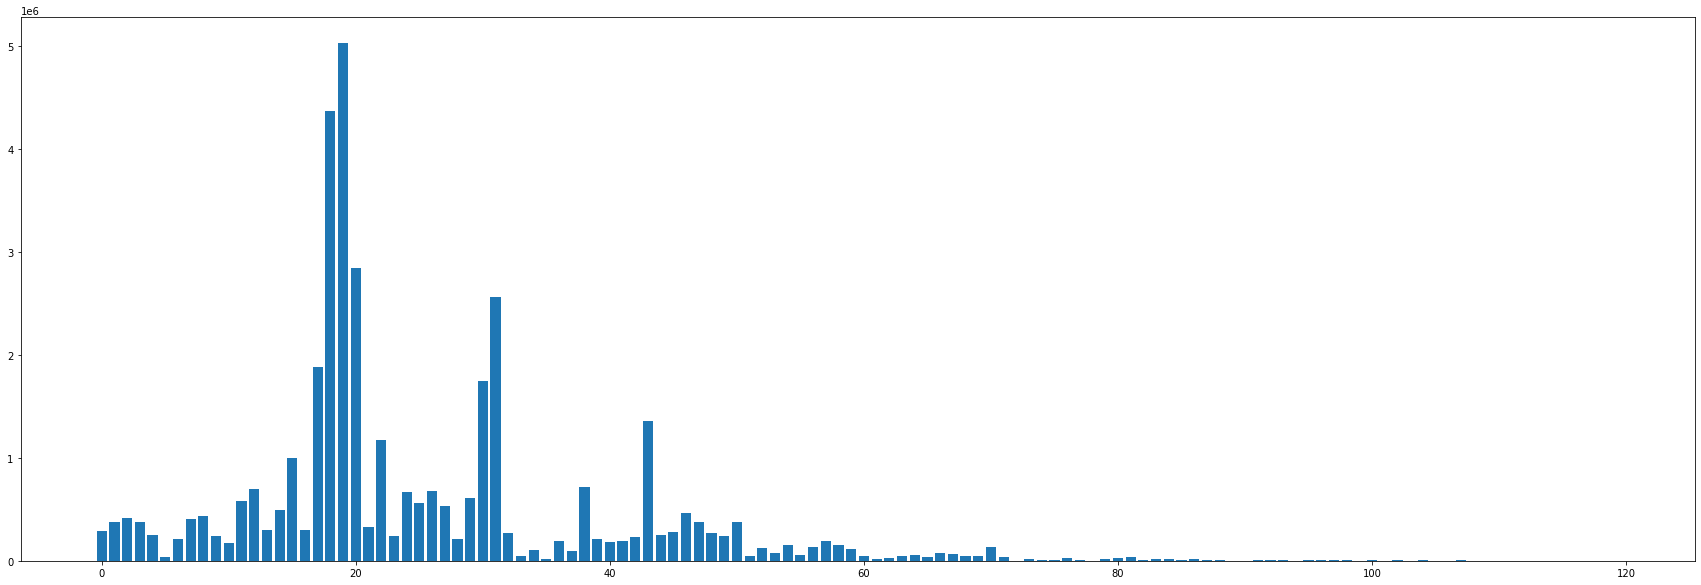

PSD of modified FFT converted to notes


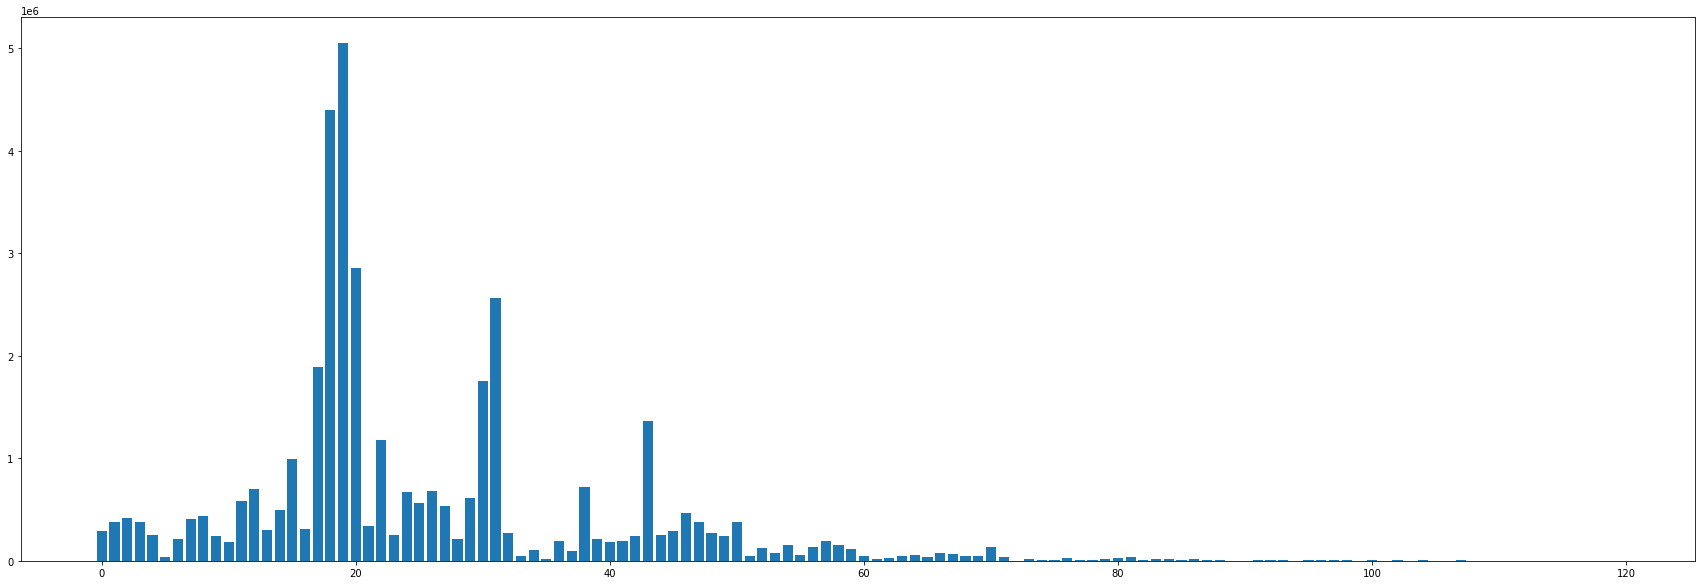

Left harmonic series


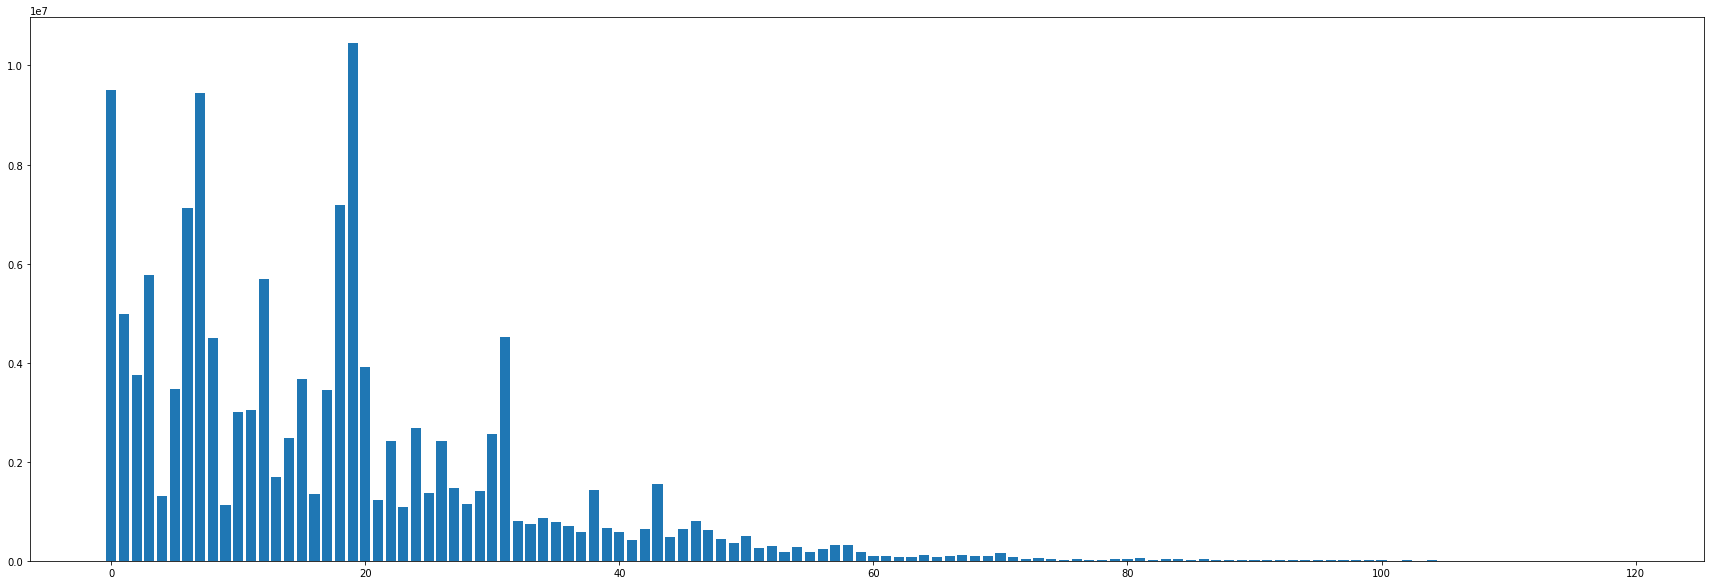

Right harmonic series


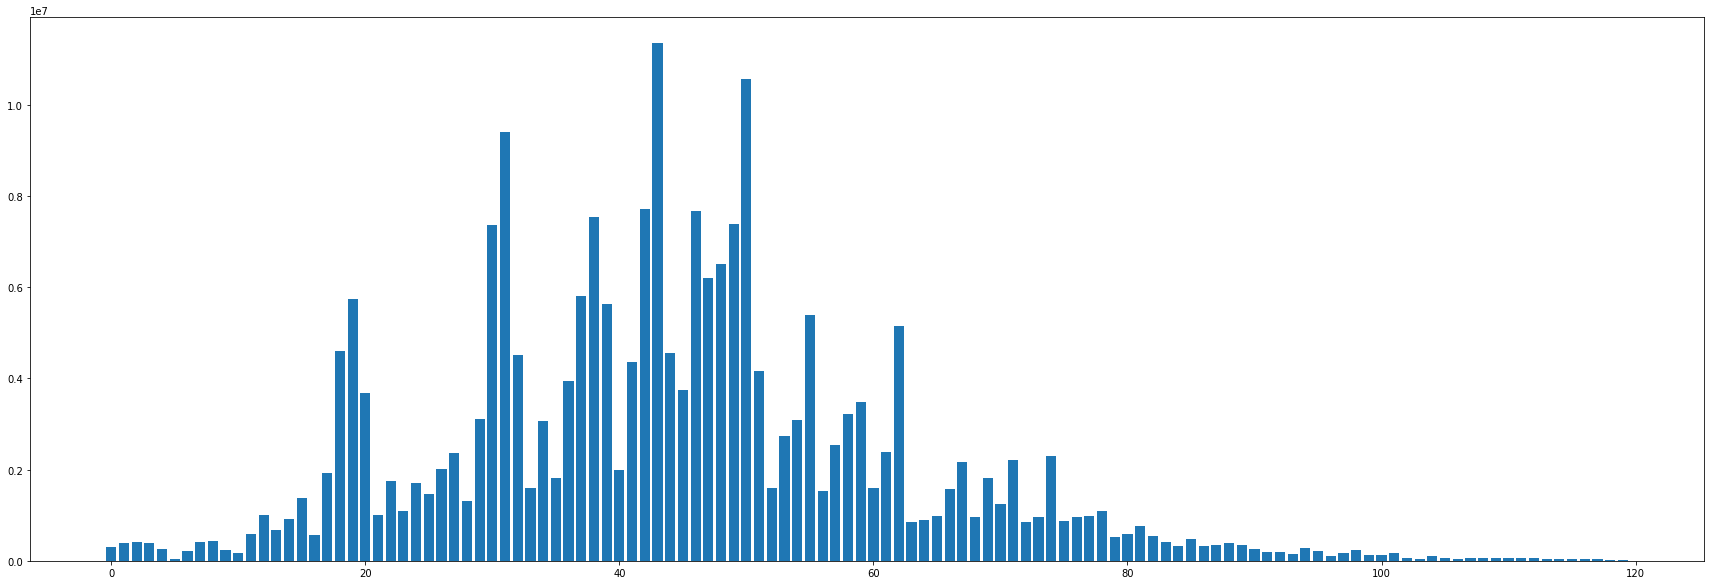

harmonic series multiplied


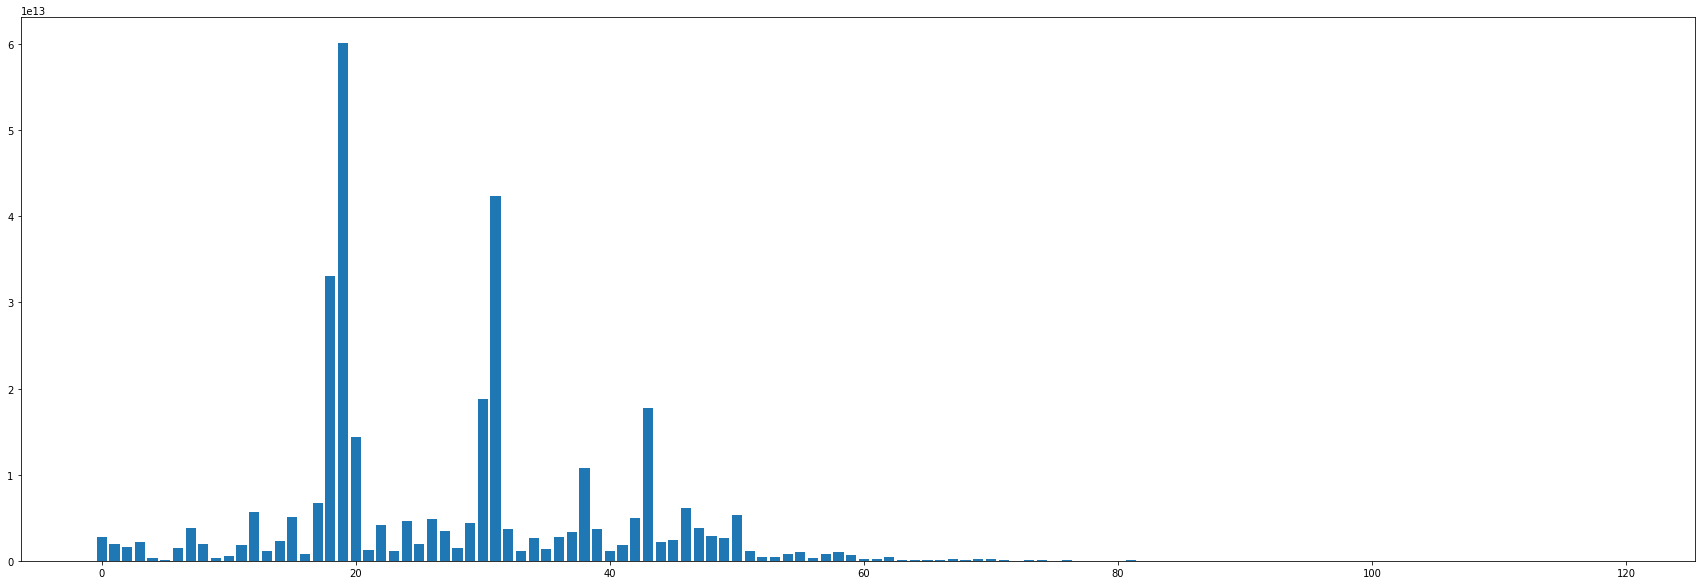

psd


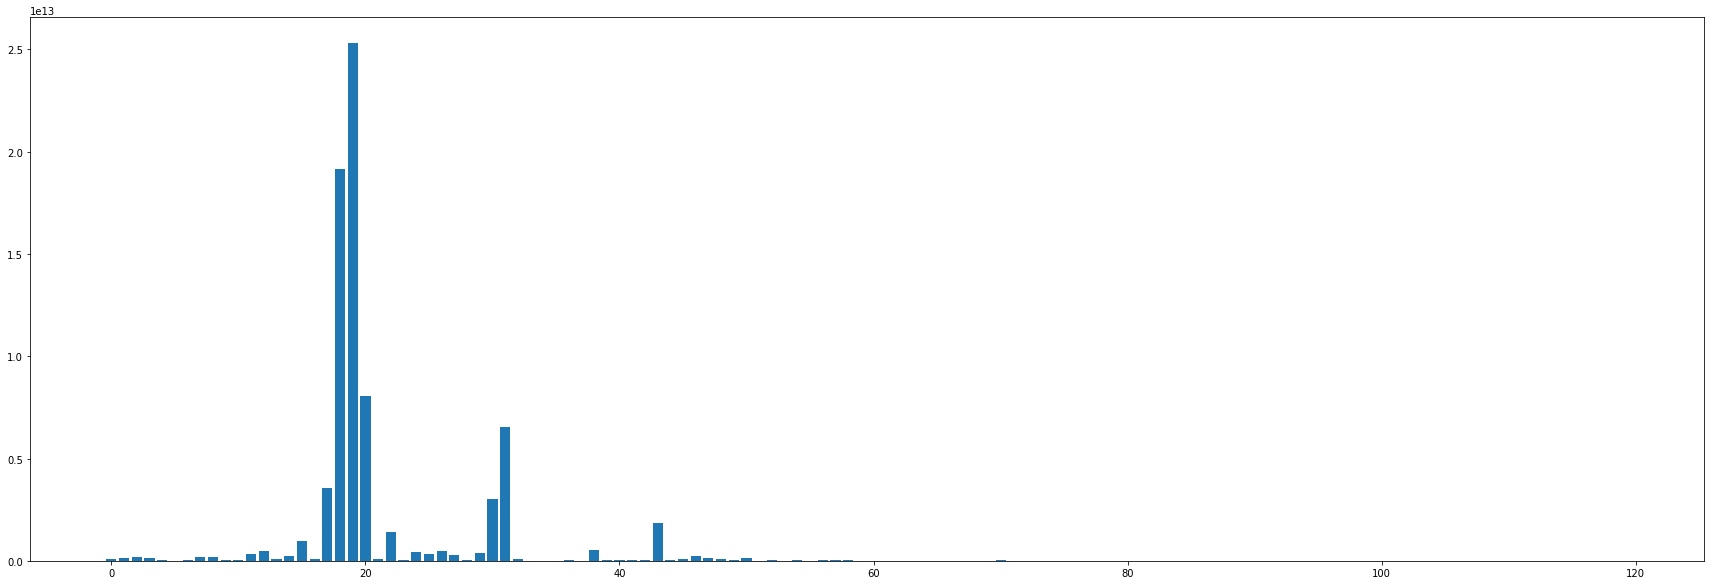

final answer


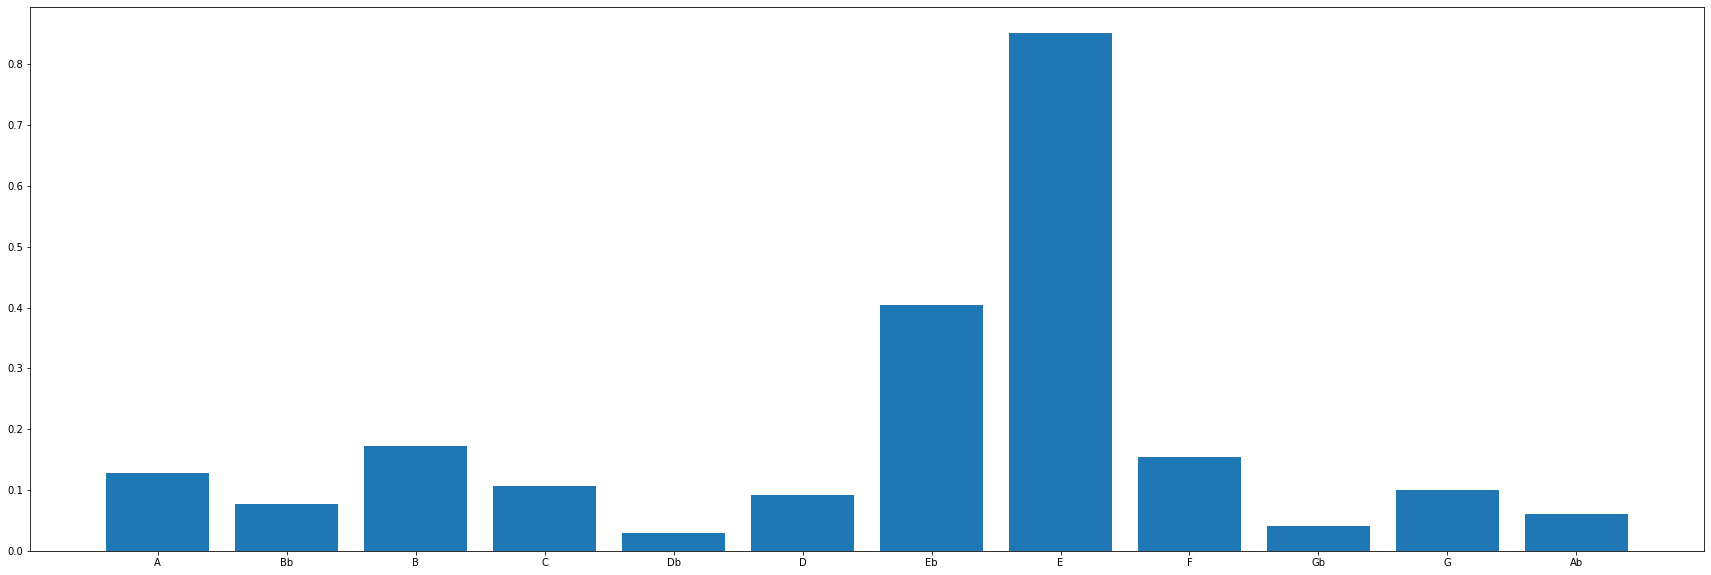

[('A', 0.1283549524701238), ('Bb', 0.07707312450573173), ('B', 0.17204796395826824), ('C', 0.1062780452332668), ('Db', 0.029629983000445868), ('D', 0.09236013682993681), ('Eb', 0.4035592028704994), ('E', 0.8514549239657386), ('F', 0.15472248793611354), ('Gb', 0.041419606484413535), ('G', 0.10029121480953589), ('Ab', 0.06109342417366203)]
final answer 2


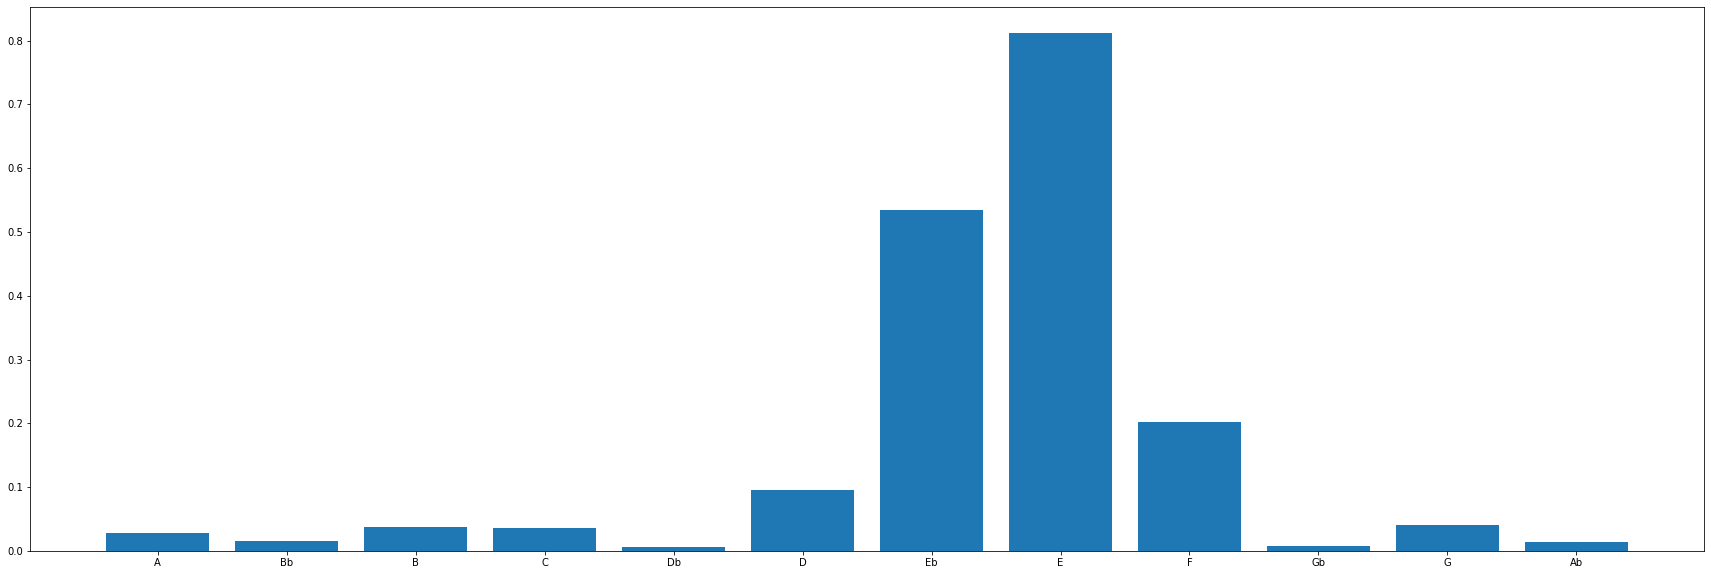

[('A', 0.02745661654184503), ('Bb', 0.01471903459146922), ('B', 0.03679019959001686), ('C', 0.035068330146621376), ('Db', 0.00603904385494625), ('D', 0.09478743280919502), ('Eb', 0.5344736441572754), ('E', 0.8119061870405301), ('F', 0.20177408537234073), ('Gb', 0.0069408696787630186), ('G', 0.04040872400129668), ('Ab', 0.013322731168136672)]
[('A', 0.1283549524701238), ('Bb', 0.07707312450573173), ('B', 0.17204796395826824), ('C', 0.1062780452332668), ('Db', 0.029629983000445868), ('D', 0.09236013682993681), ('Eb', 0.4035592028704994), ('E', 0.8514549239657386), ('F', 0.15472248793611354), ('Gb', 0.041419606484413535), ('G', 0.10029121480953589), ('Ab', 0.06109342417366203)]


In [199]:
n = find_note(sample, nfft_s, nfft_c, mat, inv_harm, condense, verbose=True)
print(n)
# plt.bar([v[0] for v in n], [v[1] for v in n])
# plt.show()

In [37]:
p = pyaudio.PyAudio()

# input("Press any key to start recording")

print("* recording")

frames = []

maxes = []

last = ""

stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    sample = np.frombuffer(data, dtype=np.int16)
    
    n = find_note(sample, nfft_s, nfft_c, mat, inv_harm, condense)
    
    n_names, n_vals = [v[0] for v in n], [v[1] for v in n]

    high_idx = np.argmax(n_vals)
    if n_vals[high_idx] > 0.5:
        note = n_names[high_idx]
        if note != last:
            last = note
            print(note)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

* recording
A
Ab
A
Bb
D
Db
C
Db
E
F
E
Eb
E
Eb
E
F
E
Gb
Bb
A
Bb
B
Bb
G
D
Db
G
B
A
Ab
E
Gb
F
E
* done recording


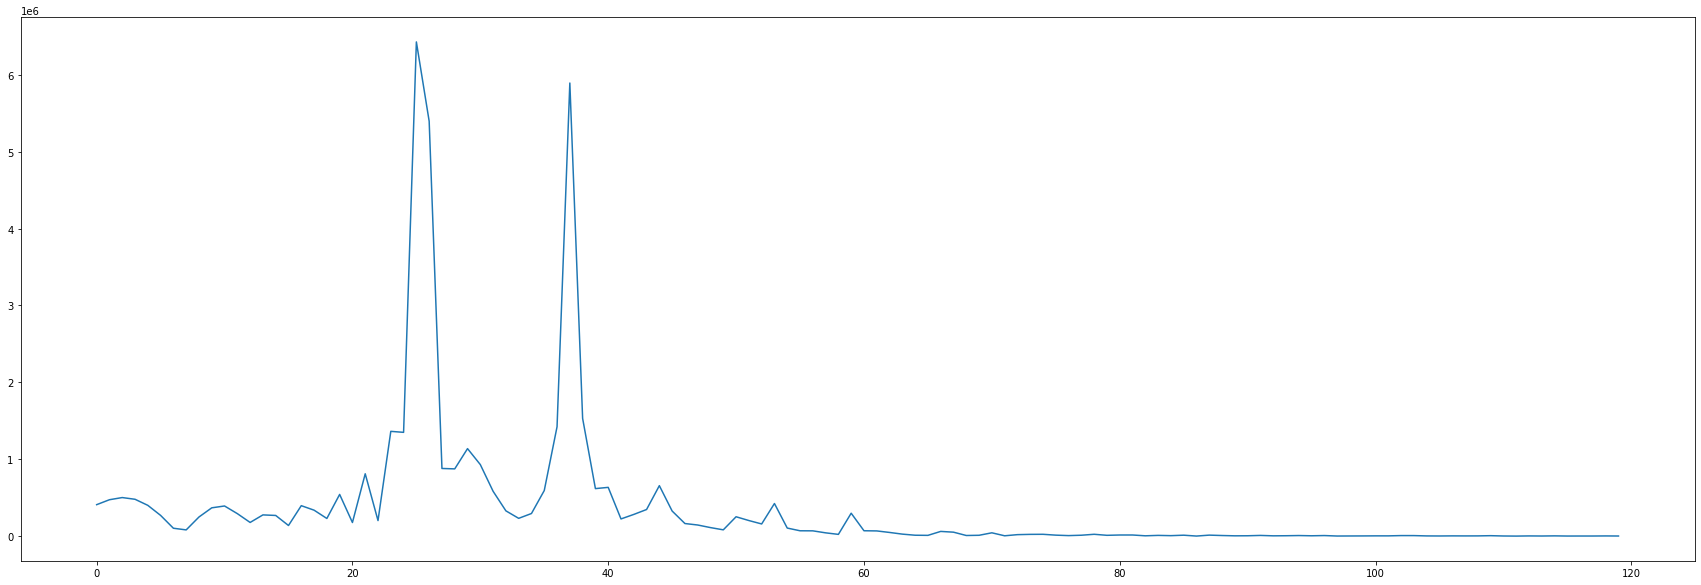

In [187]:
dft2s = np.matmul(nfft_s, sample)
dft2c = np.matmul(nfft_c, sample)

psd2 = ((dft2s**2) + (dft2c**2))**0.5
plt.plot(psd2)

In [ ]:
# Traditional FFT
""" 
fft_sin = np.zeros((slen//2, slen))
fft_cos = np.zeros((slen//2, slen))

for i in range(slen//2):
    for j in range(slen):
        fft_sin[i][j] = (i*j*np.pi*2/(2048))
        fft_cos[i][j] = (i*j*np.pi*2/(2048)) 

fft_sin = np.sin(fft_sin)
fft_cos = np.sin(fft_cos)

dfts = np.matmul(fft_sin, sample)
dftc = np.matmul(fft_cos, sample)
psd = ((dfts**2) + (dftc**2))**0.5
plt.plot(psd)
plt.show()
"""
pass

In [188]:
avgs_long = []
avgs_short = []
avgs_noc = []
for i in range(10000):
    sample2 = np.random.rand(slen)
    s = time()
    n = find_note(sample2, nfft_s, nfft_c, mat, inv_harm, condense)
    e = time()
    avgs_long.append(e-s)
    
    s = time()
    n = find_note_2(sample2, nfft_s, nfft_c, condense)
    e = time()
    avgs_short.append(e-s)
    
    s = time()
    n = find_note_3(sample2, nfft_s, nfft_c)
    e = time()
    avgs_noc.append(e-s)
    
print(np.average(avgs_long) / (1/44100), np.average(avgs_long)) #takes about 10 samples to figure out, or about 0.00023 seconds
print(np.average(avgs_short) / (1/44100), np.average(avgs_short)) #takes about 8 samples to figure out, or about 0.00015 seconds
print(np.average(avgs_noc) / (1/44100), np.average(avgs_noc)) #takes about 8 samples to figure out, or about 0.00015 seconds


61.839383933544156 0.0014022536039352417
29.966606426239014 0.0006795148849487305
62.38325292348862 0.0014145862340927125
